# Oppgave 1

Innledning goes here

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



Oppgave 1a)

In [ ]:
#Oppgave 1a)
#Defining params

A = 0.1
epsilon = 0.25
omega = 1

In [17]:
# Defining given functions

def a(t):
    return epsilon * np.sin(omega * t)

def b(t):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x, t):
    return a(t) * x**2 + b(t) * x

def fDelX(x, t):
    return 2 * a(t) * x + b(t)

def vX(x, y, t):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x, y, t):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)


def coordDerived(coords, t):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

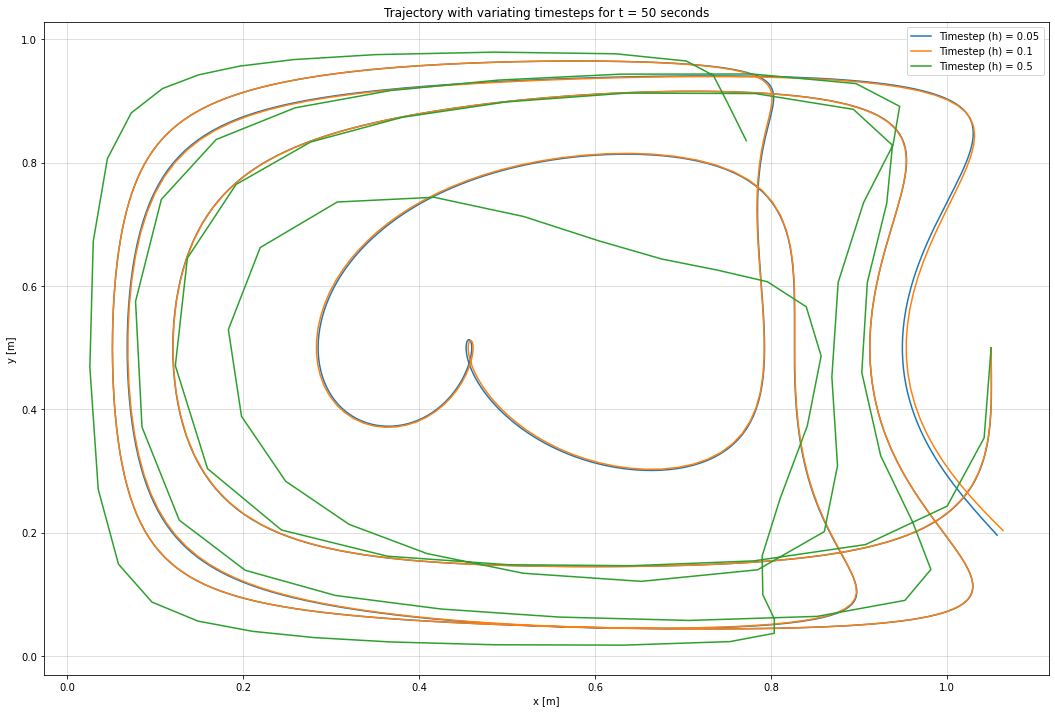

In [53]:
# Giving initial value to the coordinates-array

def Heun(h, tEnd, initPos, f):
    tList = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(tList)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(tList)):
        coordI = coordArr[:,:,i-1]
        ti = tList[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = coordI +h/2*(k1 + k2)

    return coordArr


plt.figure(figsize=(18, 12))
plt.title("Trajectory with variating timesteps for t = 50 seconds")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

pos0 = np.zeros((2,1))
pos0[0:,] = 1.05
pos0[1:,] = 0.5

hVals = [0.05, 0.1, 0.5]

for h in hVals:
     trajectory = Heun(h, 50, pos0, coordDerived)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Timestep (h) = {h}")
     plt.grid(alpha=0.5)
     plt.legend()

What seems like a reasonable timestep?
What happens if you double the time? Is same timestep good?

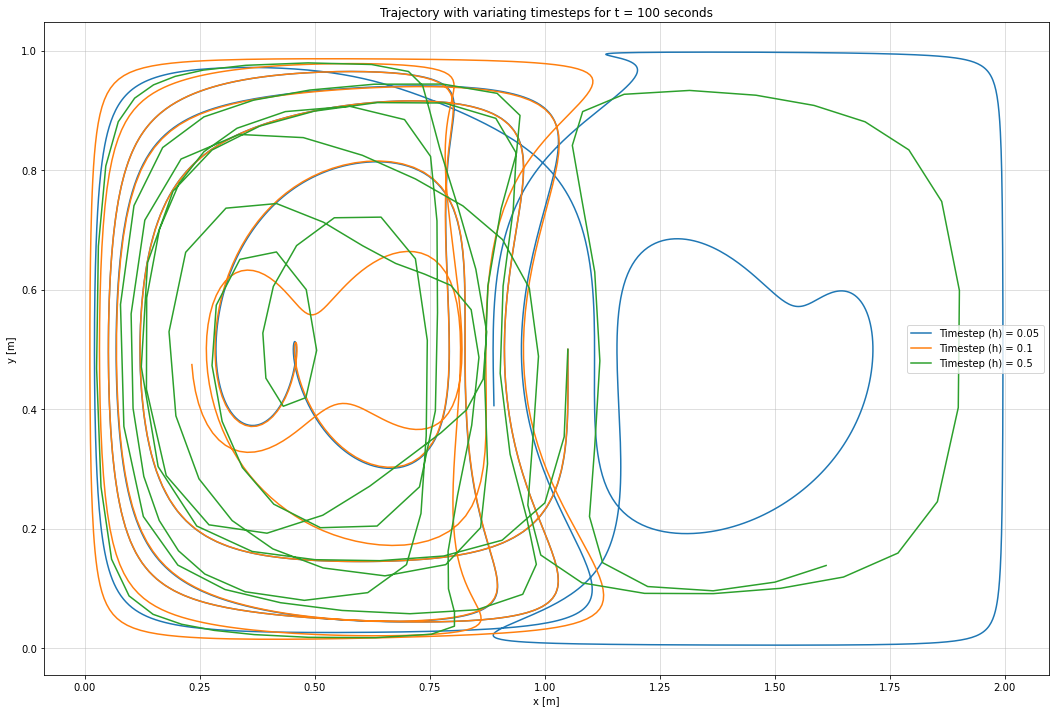

In [54]:
#Double the time?

plt.figure(figsize=(18, 12))
plt.title("Trajectory with variating timesteps for t = 100 seconds")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

for h in hVals:
     trajectory = Heun(h, 100, pos0, coordDerived)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Timestep (h) = {h}")
     plt.grid(alpha=0.5)
     plt.legend()

1b)

In [ ]:
# 100 initial conditions, calculate trajectory for each particle for t \in [0,10]
# In the same plot, show scatters of initial and final pos, as well as trajectories that
# connect.



1c)

In [ ]:
# Test implementation by measuring time to run for different numbers of particles, plot of runtime as function of N_p


Why is the run time approx. constant for small N_p?


2a)

In [20]:
#2a
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])
    

In [21]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)



# create some positions
mean_x = 790000
mean_y = 490000
standard_dev = 10000

Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = Heun(3600,3600*5*24,X, f)
# scatter plot positions, note the extra transform keyword

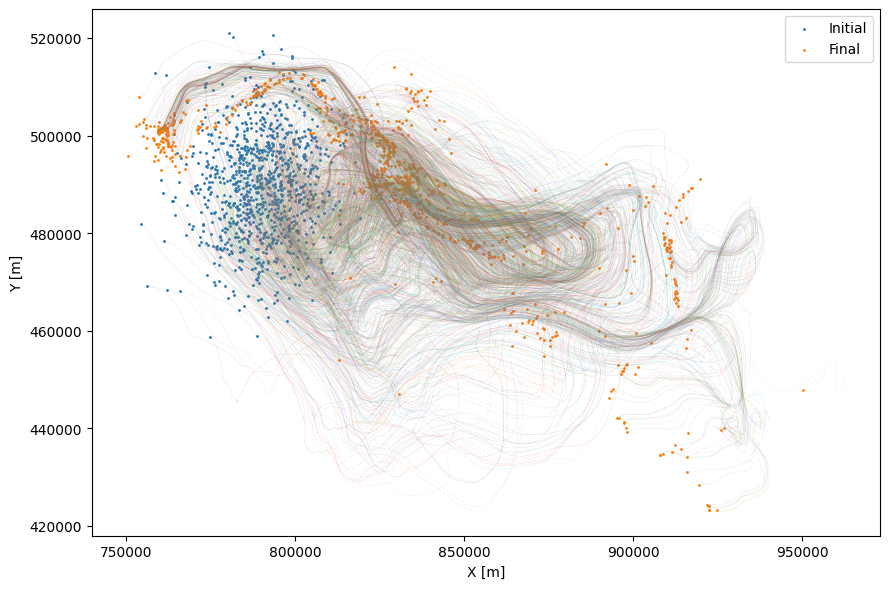

In [22]:
#Plot i xy-planet

fig = plt.figure(figsize=(9,6))
ax= plt.axes()

ax.scatter(X[0,:], X[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
plt.tight_layout()

Kommenter plott

2b)

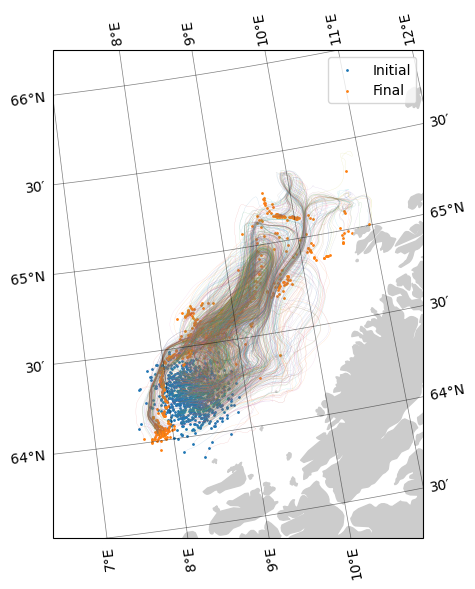

In [23]:
#Plot på kartet
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

ax.scatter(X[0,:], X[1,:], s=1, transform=npstere, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, transform=npstere, label='Final')



# Make outline a bit larger
ax.set_extent((7, 11, 63.5, 66))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

Kommenter plott

In [ ]:
# Using figs 1 and 2, try selecting other positions, and repeat simulation

# Kattegat, Saltstraumen, nord

3

In [24]:
def HeunWithStop(h, tEnd, initPos, f):
    tList = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(tList)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(tList)):
        coordI = coordArr[:,:,i-1]
        ti = tList[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = np.where(f.on_land(coordArr[:,:,i-1]),coordI,coordI +h/2*(k1 + k2))

    return coordArr



3a)

In [ ]:
mean_x = 250000
mean_y = 460000
standard_dev = 10000


Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = HeunWithStop(3600,3600*5*24,X, f)

(2, 126)


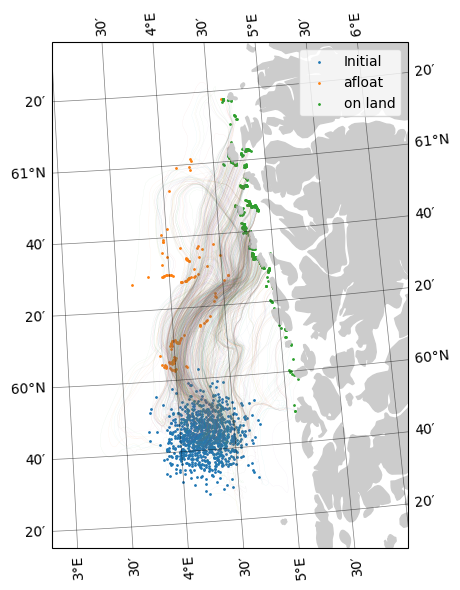

In [25]:
#Plot på kartet
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

ax.scatter(X[0,:], X[1,:], s=1, transform=npstere, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.2)

final_pos = E[:,:,-1]
afloat = final_pos[:,f.on_land(final_pos)==False]
stranded = final_pos[:,f.on_land(final_pos)==True]

print(afloat.shape)

ax.scatter(afloat[0,:], afloat[1,:], s=1, transform=npstere, label='afloat')
ax.scatter(stranded[0,:], stranded[1,:], s=1, transform=npstere, label='on land')





# Make outline a bit larger
# ax.set_extent((7, 11, 63.5, 65))
#ax.set_extent((2, 7, 60, 61.5))
ax.set_extent((3, 6, 59.25, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


ax.legend()
plt.tight_layout()

Kommenter

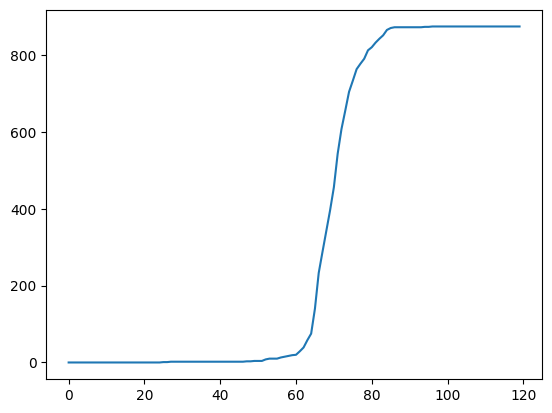

In [26]:
num_stranded = np.zeros(E.shape[-1])
for i in range(E.shape[-1]):
    num_stranded[i] = np.count_nonzero(f.on_land(E[:,:,i]))

plt.plot(num_stranded)

Kommenter

3b)

In [ ]:
# Try different windage factors and how they affect results, for example
# percentage of stranded after three days as function of f_w.

Oppsummering

Kilde